# P4 : Segmenter les clients d'un e-commerce : stabilité du modèle

## Sommaire

* [Importation et format des données](#chapter1)
* [Pèriodicité de réentraînement du modèle](#chapter2)
    * [Création du dataframe](#section_2_1)
    * [Création des fonctions de segmentation](#section_2_2)
    * [Entraînement du modèle kmeans sur les 6 1ers mois de données](#section_2_3)
    * [Segmentations par modèle entraîné sur les 6 1ers mois](#section_2_4)
    * [Segmentation par modèle entraîné glissant](#section_2_5)
    * [Calcul du ARI score](#section_2_6)

In [1]:
import numpy as np
import pandas as pd
from collections import Counter as count
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from functions import *
import statistics
from sklearn.metrics import adjusted_rand_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

## Importation et format des données <a class="anchor" id="chapter1"></a>

In [2]:
data = pd.read_csv("data.csv", index_col="customer_unique_id")

In [3]:
data.shape

(91492, 13)

In [4]:
data.head()

,nb_customer_id,nb_orders,mean_order_price,review_score_mean,freq_review_comment,freq_payment_type,payment_seq_mean,product_description_details_mean,order_item_id_mean,taux_livrs_mean,react_review_mean,shipping_day_nb_mean,freq_local_seller
customer_unique_id,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,1.0,129.90,5.0,Complet message,credit_card,8.0,141.60,1.0,9.0,1.0,5.0,Yes
0000b849f77a49e4a4ce2b2a4ca5be3f,1,1.0,18.90,4.0,No message,credit_card,1.0,355.60,1.0,44.0,1.0,4.0,Yes
0000f46a3911fa3c0805444483337064,1,1.0,69.00,3.0,No message,credit_card,8.0,260.19,1.0,25.0,1.0,5.0,No
0000f6ccb0745a6a4b88665a16c9f078,1,1.0,25.99,4.0,Message,credit_card,4.0,3743.15,1.0,68.0,1.0,6.0,No
0004aac84e0df4da2b147fca70cf8255,1,1.0,180.00,5.0,No message,credit_card,6.0,1381.56,1.0,9.0,1.0,8.0,Yes


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91492 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nb_customer_id                    91492 non-null  int64  
 1   nb_orders                         91492 non-null  float64
 2   mean_order_price                  91492 non-null  float64
 3   review_score_mean                 91492 non-null  float64
 4   freq_review_comment               91492 non-null  object 
 5   freq_payment_type                 91492 non-null  object 
 6   payment_seq_mean                  91492 non-null  float64
 7   product_description_details_mean  91492 non-null  float64
 8   order_item_id_mean                91492 non-null  float64
 9   taux_livrs_mean                   91492 non-null  float64
 10  react_review_mean                 91492 non-null  float64
 11  shipping_day_n

In [6]:
data.describe()

,nb_customer_id,nb_orders,mean_order_price,review_score_mean,payment_seq_mean,product_description_details_mean,order_item_id_mean,taux_livrs_mean,react_review_mean,shipping_day_nb_mean
count,91492.000000,91492.000000,91492.000000,91492.000000,91492.000000,91492.000000,91492.000000,91492.000000,91492.000000,91492.000000
mean,1.036167,1.237540,137.520862,4.154653,2.970932,985.500793,1.070659,30.890630,0.453464,6.637521
std,0.218633,0.844299,208.615637,1.279189,2.764153,1515.706767,0.265944,31.308329,4.601267,3.658768
min,1.000000,1.000000,0.850000,1.000000,0.000000,1.720000,1.000000,0.000000,-186.000000,2.000000
25%,1.000000,1.000000,46.039107,4.000000,1.000000,231.710000,1.000000,13.000000,1.000000,5.000000
50%,1.000000,1.000000,86.900000,5.000000,2.000000,474.800000,1.000000,23.000000,1.000000,6.000000
75%,1.000000,1.000000,149.900000,5.000000,4.000000,1094.400000,1.000000,38.000000,1.000000,7.000000
max,17.000000,75.000000,13440.000000,5.000000,48.000000,29128.680000,11.000000,2145.000000,67.000000,529.000000


In [7]:
data.isna().mean()

nb_customer_id                      0.0
nb_orders                           0.0
mean_order_price                    0.0
review_score_mean                   0.0
freq_review_comment                 0.0
freq_payment_type                   0.0
payment_seq_mean                    0.0
product_description_details_mean    0.0
order_item_id_mean                  0.0
taux_livrs_mean                     0.0
react_review_mean                   0.0
shipping_day_nb_mean                0.0
freq_local_seller                   0.0
dtype: float64

## Pèriodicité de réentraînement du modèle <a class="anchor" id="chapter2"></a>

### Création du dataframe <a class="anchor" id="section_2_1"></a>

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91492 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nb_customer_id                    91492 non-null  int64  
 1   nb_orders                         91492 non-null  float64
 2   mean_order_price                  91492 non-null  float64
 3   review_score_mean                 91492 non-null  float64
 4   freq_review_comment               91492 non-null  object 
 5   freq_payment_type                 91492 non-null  object 
 6   payment_seq_mean                  91492 non-null  float64
 7   product_description_details_mean  91492 non-null  float64
 8   order_item_id_mean                91492 non-null  float64
 9   taux_livrs_mean                   91492 non-null  float64
 10  react_review_mean                 91492 non-null  float64
 11  shipping_day_n

In [9]:
df_orders = pd.read_csv("olist_orders_dataset.csv")

In [10]:
df_customers = pd.read_csv("olist_customers_dataset.csv")

In [11]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [12]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [13]:
order_date = df_orders.merge(
    df_customers, how="left", left_on="customer_id", right_on="customer_id"
)

In [14]:
order_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
 8   customer_unique_id             99441 non-null  object
 9   customer_zip_code_prefix       99441 non-null  int64 
 10  customer_city                  99441 non-null  object
 11  customer_state                 99441 non-null  object
dtypes: int64(1), object(11)
memory usage: 9.9+ MB


In [15]:
order_date.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [16]:
order_date = order_date.drop(["order_id"], axis=1)

In [17]:
order_date = order_date.drop(
    [
        "customer_id",
        "order_status",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
        "customer_city",
        "customer_zip_code_prefix",
        "customer_state",
    ],
    axis=1,
)

In [18]:
order_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   order_purchase_timestamp  99441 non-null  object
 1   customer_unique_id        99441 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [19]:
data_date = data.merge(
    order_date, how="left", left_on="customer_unique_id", right_on="customer_unique_id"
)

In [20]:
data_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94801 entries, 0 to 94800
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_unique_id                94801 non-null  object 
 1   nb_customer_id                    94801 non-null  int64  
 2   nb_orders                         94801 non-null  float64
 3   mean_order_price                  94801 non-null  float64
 4   review_score_mean                 94801 non-null  float64
 5   freq_review_comment               94801 non-null  object 
 6   freq_payment_type                 94801 non-null  object 
 7   payment_seq_mean                  94801 non-null  float64
 8   product_description_details_mean  94801 non-null  float64
 9   order_item_id_mean                94801 non-null  float64
 10  taux_livrs_mean                   94801 non-null  float64
 11  react_review_mean                 94801 non-null  float64
 12  ship

In [21]:
data_date.isna().mean()

customer_unique_id                  0.0
nb_customer_id                      0.0
nb_orders                           0.0
mean_order_price                    0.0
review_score_mean                   0.0
freq_review_comment                 0.0
freq_payment_type                   0.0
payment_seq_mean                    0.0
product_description_details_mean    0.0
order_item_id_mean                  0.0
taux_livrs_mean                     0.0
react_review_mean                   0.0
shipping_day_nb_mean                0.0
freq_local_seller                   0.0
order_purchase_timestamp            0.0
dtype: float64

In [22]:
def select_jour(date: str) -> str:
    """
    Permet de racourcir les dates en format string. Ne conserve que le mois, le jour et l'année.

    Parametres
    ----------
    date : objet string

    Returns
    -------
    date racourcie : objet string
    """
    return date[:10]

In [23]:
def date_format(date: str) -> object :
    """
    Permet de transformer les dates en format string en format datetime64.

    Parametres
    ----------
    date : objet string

    Returns
    -------
    date : objet datetime64
    """
    date_f = datetime.strptime(date, "%Y-%m-%d")
    return date_f

In [24]:
data_date["order_purchase_timestamp"] = data_date["order_purchase_timestamp"].apply(
    select_jour
)

In [25]:
data_date["order_purchase_timestamp"] = data_date.apply(
    lambda r: date_format(r["order_purchase_timestamp"]), axis=1
)

In [26]:
data_date["order_purchase_timestamp"].head()

0   2018-05-10
1   2018-05-07
2   2017-03-10
3   2017-10-12
4   2017-11-14
Name: order_purchase_timestamp, dtype: datetime64[ns]

In [27]:
data_date["order_purchase_timestamp"].describe()

C:\Users\n_a_e\AppData\Local\Temp\ipykernel_14448\967412676.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data_date["order_purchase_timestamp"].describe()


count                   94801
unique                    621
top       2017-11-24 00:00:00
freq                     1133
first     2016-10-03 00:00:00
last      2018-10-16 00:00:00
Name: order_purchase_timestamp, dtype: object

In [28]:
data_date["order_purchase_timestamp_num"] = pd.to_numeric(
    data_date["order_purchase_timestamp"]
)

In [29]:
data_date["order_purchase_timestamp_num"].head()

0    1525910400000000000
1    1525651200000000000
2    1489104000000000000
3    1507766400000000000
4    1510617600000000000
Name: order_purchase_timestamp_num, dtype: int64

In [30]:
# valeur numéric correspondant à 1 jour nécessaire pour les calculs.
day_num = 86400000000000

### Création des fonctions de segmentation <a class="anchor" id="section_2_2"></a>

In [31]:
def model_time_predict(max_date: int) -> np.ndarray:
    """
    Segmente les données sur une plage de temps définie, en utilisant un modèle kmeans entraîné sur les 6 1ers mois.

    Parametres
    ----------
    max_date : objet string

    Returns
    -------
    labels : np.ndarray, segmentation des données.
    """
    # Sélection des données correspondant à la plage de temps
    data_date_delta = data_date[data_date["order_purchase_timestamp_num"] < max_date]
    # Suppression des variables inutiles pour préparation à l'encodage
    data_date_delta = data_date_delta.drop(
        [
            "order_purchase_timestamp_num",
            "order_purchase_timestamp",
            "customer_unique_id",
        ],
        axis=1,
    )

    # Transformation des variables discrètes en integer
    data_date_delta["review_score_mean"] = data_date_delta["review_score_mean"].astype(
        int
    )
    data_date_delta["order_item_id_mean"] = data_date_delta[
        "order_item_id_mean"
    ].astype(int)
    data_date_delta["react_review_mean"] = data_date_delta["react_review_mean"].astype(
        int
    )
    data_date_delta["shipping_day_nb_mean"] = data_date_delta[
        "shipping_day_nb_mean"
    ].astype(int)
    data_date_delta["nb_customer_id"] = data_date_delta["nb_customer_id"].astype(int)

    # Encodage et concaténation des variables de catégories
    comment = pd.get_dummies(data_date_delta["freq_review_comment"], prefix="Comment")
    payment_type = pd.get_dummies(
        data_date_delta["freq_payment_type"], prefix="Payment"
    )
    local_seller = pd.get_dummies(
        data_date_delta["freq_local_seller"], prefix="loc_seller"
    )

    data_date_delta_encod = pd.concat([comment, payment_type, local_seller], axis=1)

    # Data frame des variables quantitatives
    data_date_delta_qtt = data_date_delta.drop(
        ["freq_review_comment", "freq_payment_type", "freq_local_seller"], axis=1
    )

    # Data frame complet
    data_date_delta_all = pd.concat(
        [data_date_delta_qtt, data_date_delta_encod], axis=1
    )

    # Analyse en composante principale pour un seuil à 95% soit pour les 15 premières composantes
    X = data_date_delta_all.dropna()
    X = StandardScaler().fit_transform(X)
    pca = decomposition.PCA(n_components=15)
    pca.fit(X)
    X = pca.transform(X)

    # Segmentation Kmeans entraîné sur les 6 1ers mois avec k=7
    model = kmeans_6m
    labels = model.predict(X)
    return labels

In [32]:
def model_time(max_date: int) -> np.ndarray:
    """
    Segmente les données sur une plage de temps définie, en utilisant un modèle kmeans entraîné sur les données actualisées.

    Parametres
    ----------
    max_date : objet string

    Returns
    -------
    labels : np.ndarray, segmentation des données.
    kmeans : model entraîné sur données actualisées.
    """
    # Sélection des données correspondant à la plage de temps
    data_date_delta = data_date[data_date["order_purchase_timestamp_num"] < max_date]
    # Suppression des variables inutiles pour préparation à l'encodage
    data_date_delta = data_date_delta.drop(
        [
            "order_purchase_timestamp_num",
            "order_purchase_timestamp",
            "customer_unique_id",
        ],
        axis=1,
    )

    # Transformation des variables discrètes en integer
    data_date_delta["review_score_mean"] = data_date_delta["review_score_mean"].astype(
        int
    )
    data_date_delta["order_item_id_mean"] = data_date_delta[
        "order_item_id_mean"
    ].astype(int)
    data_date_delta["react_review_mean"] = data_date_delta["react_review_mean"].astype(
        int
    )
    data_date_delta["shipping_day_nb_mean"] = data_date_delta[
        "shipping_day_nb_mean"
    ].astype(int)
    data_date_delta["nb_customer_id"] = data_date_delta["nb_customer_id"].astype(int)

    # Encodage et concaténation des variables de catégories
    comment = pd.get_dummies(data_date_delta["freq_review_comment"], prefix="Comment")
    payment_type = pd.get_dummies(
        data_date_delta["freq_payment_type"], prefix="Payment"
    )
    local_seller = pd.get_dummies(
        data_date_delta["freq_local_seller"], prefix="loc_seller"
    )

    data_date_delta_encod = pd.concat([comment, payment_type, local_seller], axis=1)

    # Data frame des variables quantitatives
    data_date_delta_qtt = data_date_delta.drop(
        ["freq_review_comment", "freq_payment_type", "freq_local_seller"], axis=1
    )

    # Data frame complet
    data_date_delta_all = pd.concat(
        [data_date_delta_qtt, data_date_delta_encod], axis=1
    )

    # Analyse en composante principale pour un seuil à 95% soit pour les 15 premières composantes
    X = data_date_delta_all.dropna()
    X = StandardScaler().fit_transform(X)
    pca = decomposition.PCA(n_components=15)
    pca.fit(X)
    X = pca.transform(X)

    # Segmentation Kmeans avec k=7
    model = KMeans(n_clusters=7)
    kmeans = model.fit(X)
    labels = kmeans.labels_
    return labels, kmeans

### Entraînement du modèle kmeans sur les 6 1ers mois de données <a class="anchor" id="section_2_3"></a>

In [33]:
# Def de la plage de temps
nb_mois = 6
min_date = min(data_date["order_purchase_timestamp_num"])
max_date = min_date + (nb_mois * 30 * day_num)

labels_6m, kmeans_6m = model_time(max_date)

In [34]:
labels_6m

array([5, 5, 5, ..., 2, 5, 5])

In [35]:
kmeans_6m

KMeans(n_clusters=7)

### Segmentations par modèle entraîné sur les 6 1ers mois <a class="anchor" id="section_2_4"></a>

In [36]:
# Je fixe les paramètres de segmentation

min_date = min(data_date["order_purchase_timestamp_num"])

nb_mois_list = range(6, 17, 1)

max_date_list = []
for nb_mois in nb_mois_list:
    max_date = min_date + nb_mois * 30 * day_num
    max_date_list.append(max_date)

# Je créer la variable de stockage des segmentations
labels_predict_all = []

# Je créé la boucle de segmentation
for i in range(len(max_date_list)):
    labels_predict = model_time_predict(max_date_list[i])
    labels_predict_all.append(labels_predict)

In [37]:
labels_predict_all[0:3]

[array([5, 5, 5, ..., 2, 5, 5]),
 array([5, 5, 5, ..., 2, 5, 5]),
 array([5, 5, 5, ..., 0, 5, 5])]

### Segmentation par modèle entraîné glissant <a class="anchor" id="section_2_5"></a>

In [38]:
# Je fixe les paramètres de segmentation
# Je fixe les paramètres de segmentation

min_date = min(data_date["order_purchase_timestamp_num"])

nb_mois_list = range(6, 17, 1)

max_date_list = []
for nb_mois in nb_mois_list:
    max_date = min_date + nb_mois * 30 * day_num
    max_date_list.append(max_date)


# Je créer la variable de stockage des segmentations
labels_all = []


# Je créé la boucle de segmentation
for i in range(len(max_date_list)):
    labels, kmeans = model_time(max_date_list[i])
    labels_all.append(labels)

In [39]:
labels_all[0:3]

[array([0, 0, 0, ..., 1, 0, 0]),
 array([0, 0, 0, ..., 5, 0, 0]),
 array([1, 1, 1, ..., 6, 1, 1])]

### Calcul du ARI score <a class="anchor" id="section_2_6"></a>

In [40]:
len(labels_predict_all)

11

In [41]:
for labels in labels_predict_all:
    print(len(labels))

5086
7323
10668
13767
17415
21344
25508
29765
36105
42209
48405


In [42]:
len(labels_all)

11

In [43]:
for labels in labels_all:
    print(len(labels))

5086
7323
10668
13767
17415
21344
25508
29765
36105
42209
48405


In [44]:
ARI_all = []

for i in range(len(labels_all)):
    ARI = round(adjusted_rand_score(labels_predict_all[i], labels_all[i]), 2)
    ARI_all.append(ARI)

In [45]:
ARI_all

[0.77, 0.79, 0.57, 0.57, 0.36, 0.38, 0.31, 0.62, 0.35, 0.36, 0.57]

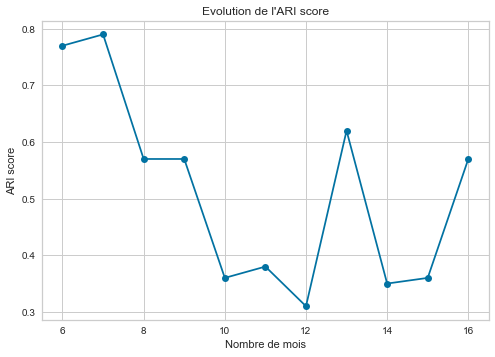

In [46]:
plt.plot(range(6, 17), ARI_all, marker="o")
plt.xlabel("Nombre de mois")
plt.ylabel("ARI score")
plt.title("Evolution de l'ARI score")
plt.show()